🚀 STARTING ENHANCED TRANSFORMER RECOMMENDATION SYSTEM
Using device: cpu

📥 LOADING AND PREPROCESSING DATA...
Train data: 90570 rows
Test data: 9430 rows
Users: 943, Items: 1682
User-item matrix shape: (943, 1682)
Sparsity: 94.29%

🎯 SETTING UP ENHANCED TRANSFORMER TRAINING...
📊 Created enhanced dataset with 181140 samples (90570 positive, 90570 negative)
📊 Enhanced Transformer Parameters: 110,174 total, 110,174 trainable

📈 Parameter Breakdown:
  User Embedding: 22,632
  Item Embedding: 40,368
  User/Item Bias: 2,625
  Transformer Layers: 23,856
  Prediction Heads: 9,890
✅ Model has 110,174 parameters (< 200,000)
✅ Enhanced Transformer model initialized on cpu

🔥 STARTING ENHANCED TRANSFORMER TRAINING...
  Batch 0: Total Loss=5.9154, Rating Loss=6.9470, RMSE=1.1523
  Batch 100: Total Loss=3.6266, Rating Loss=4.2153, RMSE=1.6980
  Batch 200: Total Loss=2.4673, Rating Loss=2.8470, RMSE=1.6491
  Batch 300: Total Loss=2.5448, Rating Loss=2.9328, RMSE=1.6883
  Batch 400: Total Loss=2.2858, 

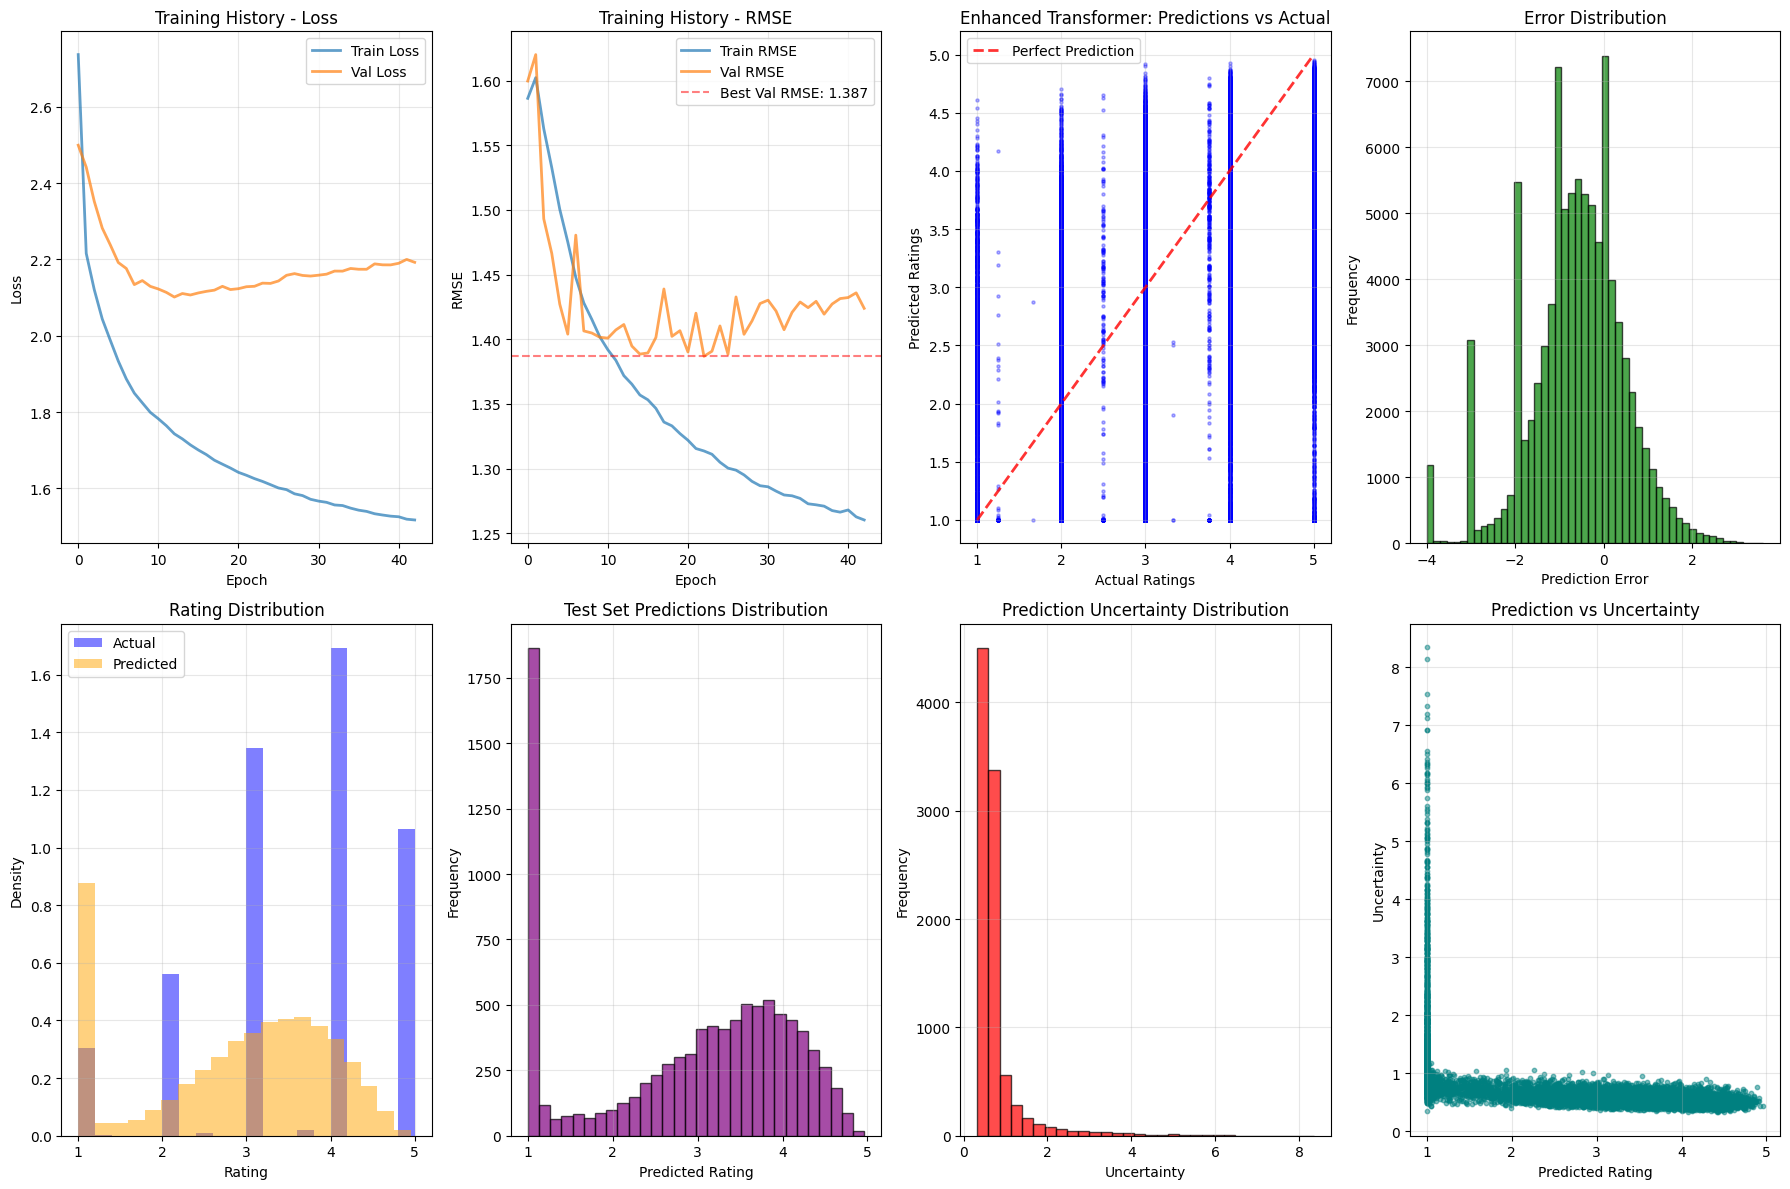


🔍 DETAILED ENHANCED TRANSFORMER EVALUATION:
📈 Enhanced Transformer Performance Metrics:
  RMSE: 1.2574
  MSE: 1.5810
  MAE: 0.9560
  MAPE: 29.38%
  R²: -0.2463
  Explained Variance: 0.0675
  Correlation: 0.5248

💾 SAVING ENHANCED MODEL AND RESULTS...
✅ Enhanced model saved as 'enhanced_transformer_recommender_final.pth'
✅ Test predictions and uncertainties saved
✅ Enhanced training history saved

🎉 ENHANCED TRANSFORMER RECOMMENDATION SYSTEM COMPLETED!
🏆 Final Train RMSE: 1.2574
🏆 Best Val RMSE: 1.3868
📤 Submission file: enhanced_transformer_submission.csv
📊 Total parameters: 110,174
🚀 Ready to submit to competition!


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import math

print("🚀 STARTING ENHANCED TRANSFORMER RECOMMENDATION SYSTEM")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ==================== 1. LOAD AND PREPARE DATA ====================
print("\n📥 LOADING AND PREPROCESSING DATA...")

# Load data
train_data = pd.read_csv('/kaggle/input/movie-recomendation-fall-2020/train.txt', 
                        sep='\t', names=['user_id', 'item_id', 'rating'])
test_data = pd.read_csv('/kaggle/input/movie-recomendation-fall-2020/test.txt', 
                       sep='\t', names=['user_id', 'item_id'])

print(f"Train data: {len(train_data)} rows")
print(f"Test data: {len(test_data)} rows")

# Get dimensions
num_users = max(train_data['user_id'].max(), test_data['user_id'].max()) #Số lượng user
num_items = max(train_data['item_id'].max(), test_data['item_id'].max()) #Số lượng item

print(f"Users: {num_users}, Items: {num_items}")

# Create user-item matrix
def create_user_item_matrix(data, num_users, num_items):
    """Create user-item rating matrix"""
    matrix = np.zeros((num_users, num_items))
    for _, row in data.iterrows():
        user_idx = int(row['user_id']) - 1 #Chỉ số đại diện cho user và item được bắt đầu từ 0 thay vì 1
        item_idx = int(row['item_id']) - 1 #Chỉ số đại diện cho user và item bắt đầu từ 0 thay vì 1
        if 0 <= user_idx < num_users and 0 <= item_idx < num_items:
            matrix[user_idx, item_idx] = row['rating']  #Chỗ này nó kỹ hiệu hơn khó hiểu : matrix[user_idx][item_idx] = row[rating]
    return matrix

# Create training matrix
train_matrix = create_user_item_matrix(train_data, num_users, num_items)
print(f"User-item matrix shape: {train_matrix.shape}")
print(f"Sparsity: {(train_matrix == 0).sum() / (num_users * num_items) * 100:.2f}%")
###--> train_matrix: là ma trận (num_user,num_item); mỗi dòng là các rating của user thứ i cho tất cả các item mà user i đang tương tác

# Normalize ratings to 0-1 range
scaler = MinMaxScaler(feature_range=(0, 1))  #Bộ chuẩn hóa các dữ liệu về khoảng [0,1]
train_matrix_normalized = scaler.fit_transform(train_matrix.T).T #Tại sao

# Create mask for observed ratings
train_mask = (train_matrix > 0).astype(np.float32) 

# ==================== 3. CREATE DATASET ====================
class EnhancedDataset(Dataset):
    def __init__(self, matrix, negative_samples=1):
        self.matrix = matrix
        self.user_item_pairs = []
        self.negative_samples = negative_samples
        
        # Collect all non-zero ratings
        user_indices, item_indices = np.where(matrix > 0)
        for user_idx, item_idx in zip(user_indices, item_indices):
            self.user_item_pairs.append({
                'user_idx': user_idx,
                'item_idx': item_idx,
                'rating': matrix[user_idx, item_idx],
                'label': 1  # Positive sample
            })
            
            # Add negative samples
            for _ in range(negative_samples):
                # Find an item not rated by the user
                user_ratings = np.where(matrix[user_idx] > 0)[0]
                all_items = np.arange(matrix.shape[1])
                negative_items = np.setdiff1d(all_items, user_ratings)
                
                if len(negative_items) > 0:
                    neg_item = np.random.choice(negative_items)
                    self.user_item_pairs.append({
                        'user_idx': user_idx,
                        'item_idx': neg_item,
                        'rating': 0.0,  # Unobserved
                        'label': 0  # Negative sample
                    })
        
        print(f"📊 Created enhanced dataset with {len(self.user_item_pairs)} samples "
              f"({len(user_indices)} positive, {len(self.user_item_pairs) - len(user_indices)} negative)")
    
    def __len__(self):
        return len(self.user_item_pairs)
    
    def __getitem__(self, idx):
        pair = self.user_item_pairs[idx]
        return (torch.tensor(pair['user_idx'], dtype=torch.long),
                torch.tensor(pair['item_idx'], dtype=torch.long),
                torch.tensor(pair['rating'], dtype=torch.float),
                torch.tensor(pair['label'], dtype=torch.float))

# ==================== 4. ADVANCED LOSS FUNCTIONS ====================
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.7, beta=0.3):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha  # Weight for rating prediction
        self.beta = beta    # Weight for ranking loss
        self.mse_loss = nn.MSELoss()
        self.bce_loss = nn.BCEWithLogitsLoss()
        
    def forward(self, predictions, targets, labels=None, logits=None):
        # Rating prediction loss
        rating_loss = self.mse_loss(predictions, targets * 5.0)
        
        # Ranking loss (if available)
        rank_loss = 0
        if labels is not None and logits is not None:
            rank_loss = self.bce_loss(logits, labels)
        
        # Combined loss
        total_loss = self.alpha * rating_loss + self.beta * rank_loss
        
        return total_loss, rating_loss, rank_loss

# ==================== 5. TRAINING SETUP ====================
print("\n🎯 SETTING UP ENHANCED TRANSFORMER TRAINING...")

# Create enhanced dataset
enhanced_dataset = EnhancedDataset(train_matrix_normalized, negative_samples=1)

# Split train/validation
train_size = int(0.9 * len(enhanced_dataset))
val_size = len(enhanced_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    enhanced_dataset, [train_size, val_size], 
    generator=torch.Generator().manual_seed(42)
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

# Initialize model with optimized parameters
model = EnhancedTransformerRecommender(
    num_users=num_users,
    num_items=num_items,
    d_model=48,      # Reduced from 64
    nhead=4,
    num_layers=1,    # Single layer to save parameters
    dropout=0.15     # Slightly higher dropout
).to(device)

print(f"✅ Enhanced Transformer model initialized on {device}")

# Combined loss function
criterion = CombinedLoss(alpha=0.8, beta=0.2)

# Advanced optimizer with gradient clipping
optimizer = optim.AdamW(
    model.parameters(),
    lr=0.001,
    weight_decay=0.01,  # Increased regularization
    betas=(0.9, 0.999)
)

# Warmup scheduler
def warmup_scheduler(epoch, warmup_epochs=5, base_lr=0.001):
    if epoch < warmup_epochs:
        return base_lr * (epoch + 1) / warmup_epochs
    else:
        return base_lr * 0.95 ** (epoch - warmup_epochs)

# ==================== 6. ADVANCED TRAINING LOOP ====================
print("\n🔥 STARTING ENHANCED TRANSFORMER TRAINING...")

def calculate_rmse(predictions, targets):
    """Calculate RMSE for predictions"""
    mse = torch.mean((predictions - targets) ** 2)
    return torch.sqrt(mse)

# Training metrics
train_losses = []
val_losses = []
train_rmses = []
val_rmses = []

best_val_rmse = float('inf')
best_model_state = None
patience = 20
patience_counter = 0

epochs = 80
for epoch in range(epochs):
    # Set learning rate with warmup
    lr = warmup_scheduler(epoch)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    
    # Training phase
    model.train()
    epoch_train_loss = 0
    epoch_train_rmse = 0
    epoch_rating_loss = 0
    epoch_rank_loss = 0
    train_batches = 0
    
    for batch_idx, (user_ids, item_ids, ratings, labels) in enumerate(train_loader):
        user_ids = user_ids.to(device)
        item_ids = item_ids.to(device)
        ratings = ratings.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass with uncertainty
        predictions = model(user_ids, item_ids)
        
        # For ranking loss, we need logits (using raw predictions before sigmoid scaling)
        logits = predictions  # Use predictions as logits for ranking
        
        # Calculate combined loss
        total_loss, rating_loss, rank_loss = criterion(
            predictions, ratings, labels, logits
        )
        
        # Calculate RMSE (only on positive samples)
        positive_mask = labels > 0.5
        if positive_mask.sum() > 0:
            rmse = calculate_rmse(predictions[positive_mask], ratings[positive_mask] * 5.0)
        else:
            rmse = torch.tensor(0.0)
        
        # Backward pass
        total_loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        # Accumulate metrics
        epoch_train_loss += total_loss.item()
        epoch_train_rmse += rmse.item()
        epoch_rating_loss += rating_loss.item()
        epoch_rank_loss += rank_loss.item()
        train_batches += 1
        
        if batch_idx % 100 == 0:
            print(f"  Batch {batch_idx}: Total Loss={total_loss.item():.4f}, "
                  f"Rating Loss={rating_loss.item():.4f}, RMSE={rmse.item():.4f}")
    
    # Validation phase
    model.eval()
    epoch_val_loss = 0
    epoch_val_rmse = 0
    val_batches = 0
    
    with torch.no_grad():
        for user_ids, item_ids, ratings, labels in val_loader:
            user_ids = user_ids.to(device)
            item_ids = item_ids.to(device)
            ratings = ratings.to(device)
            
            predictions = model(user_ids, item_ids)
            
            # Calculate validation loss (only rating loss for validation)
            val_loss = criterion.mse_loss(predictions, ratings * 5.0)
            
            # Calculate RMSE on positive samples
            positive_mask = labels > 0.5
            if positive_mask.sum() > 0:
                val_rmse = calculate_rmse(predictions[positive_mask], ratings[positive_mask] * 5.0)
            else:
                val_rmse = torch.tensor(0.0)
            
            epoch_val_loss += val_loss.item()
            epoch_val_rmse += val_rmse.item()
            val_batches += 1
    
    # Calculate averages
    avg_train_loss = epoch_train_loss / train_batches
    avg_train_rmse = epoch_train_rmse / train_batches
    avg_rating_loss = epoch_rating_loss / train_batches
    avg_rank_loss = epoch_rank_loss / train_batches
    avg_val_loss = epoch_val_loss / val_batches
    avg_val_rmse = epoch_val_rmse / val_batches
    
    # Store metrics
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_rmses.append(avg_train_rmse)
    val_rmses.append(avg_val_rmse)
    
    # Early stopping check
    if avg_val_rmse < best_val_rmse:
        best_val_rmse = avg_val_rmse
        best_model_state = model.state_dict().copy()
        patience_counter = 0
        torch.save(model.state_dict(), 'best_enhanced_transformer_model.pth')
        print(f"💾 Saved best model with Val RMSE: {best_val_rmse:.4f}")
    else:
        patience_counter += 1
    
    # Print epoch summary
    print(f"Epoch {epoch+1:3d}/{epochs}: "
          f"LR={lr:.6f}, "
          f"Train Loss={avg_train_loss:.4f} (R={avg_rating_loss:.4f}, Rn={avg_rank_loss:.4f}), "
          f"Train RMSE={avg_train_rmse:.4f}, "
          f"Val Loss={avg_val_loss:.4f}, Val RMSE={avg_val_rmse:.4f}")
    
    # Early stopping
    if patience_counter >= patience:
        print(f"⏹️  Early stopping triggered at epoch {epoch+1}")
        break

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"✅ Loaded best model with Val RMSE: {best_val_rmse:.4f}")

# ==================== 7. EVALUATE ON TRAINING SET ====================
print("\n📊 EVALUATING ENHANCED TRANSFORMER ON TRAINING SET...")

# Create data loader for positive samples only
positive_pairs = []
user_indices, item_indices = np.where(train_matrix_normalized > 0)
for user_idx, item_idx in zip(user_indices, item_indices):
    positive_pairs.append((user_idx, item_idx, train_matrix_normalized[user_idx, item_idx]))

positive_loader = DataLoader(
    [(torch.tensor(u), torch.tensor(i), torch.tensor(r)) for u, i, r in positive_pairs],
    batch_size=512,
    shuffle=False
)

model.eval()
all_predictions = []
all_ratings = []

with torch.no_grad():
    for user_ids, item_ids, ratings in positive_loader:
        user_ids = user_ids.to(device)
        item_ids = item_ids.to(device)
        
        predictions = model(user_ids, item_ids)
        
        all_predictions.extend(predictions.cpu().numpy())
        all_ratings.extend((ratings * 5.0).numpy())

all_predictions = np.array(all_predictions)
all_ratings = np.array(all_ratings)

# Calculate final RMSE
final_rmse = np.sqrt(np.mean((all_predictions - all_ratings) ** 2))
print(f"✅ FINAL TRAIN RMSE: {final_rmse:.4f}")

# ==================== 8. MAKE TEST PREDICTIONS ====================
print("\n🎯 MAKING PREDICTIONS FOR TEST SET...")

def predict_batch_enhanced(model, user_ids, item_ids, batch_size=2048, device=device):
    """Make predictions in batches"""
    model.eval()
    all_predictions = []
    all_uncertainties = []
    
    num_samples = len(user_ids)
    
    with torch.no_grad():
        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            
            batch_users = torch.tensor(user_ids[start_idx:end_idx], dtype=torch.long, device=device)
            batch_items = torch.tensor(item_ids[start_idx:end_idx], dtype=torch.long, device=device)
            
            batch_preds, batch_unc = model(batch_users, batch_items, return_uncertainty=True)
            all_predictions.extend(batch_preds.cpu().numpy())
            all_uncertainties.extend(batch_unc.cpu().numpy())
    
    return np.array(all_predictions), np.array(all_uncertainties)

# Prepare test data
test_user_indices = test_data['user_id'].values - 1
test_item_indices = test_data['item_id'].values - 1

# Make predictions with uncertainty
print(f"Making predictions for {len(test_data)} test samples...")
test_predictions, test_uncertainties = predict_batch_enhanced(
    model, test_user_indices, test_item_indices, batch_size=2048
)

# Clip predictions to valid range
test_predictions = np.clip(test_predictions, 1.0, 5.0)

# ==================== 9. CREATE SUBMISSION ====================
print("\n📝 CREATING ENHANCED SUBMISSION FILE...")

def create_enhanced_submission(test_data, predictions, uncertainties=None, output_file='enhanced_transformer_submission.csv'):
    """Create submission file with optional uncertainty information"""
    
    submission_lines = ["Id,Score"]
    
    for idx, pred in enumerate(predictions):
        # Optionally adjust predictions based on uncertainty
        if uncertainties is not None:
            # Conservative adjustment: pull uncertain predictions towards mean (3.0)
            uncertainty_weight = min(uncertainties[idx] / 2.0, 1.0)
            adjusted_pred = pred * (1 - uncertainty_weight) + 3.0 * uncertainty_weight
            pred = adjusted_pred
        
        submission_lines.append(f"{idx+1},{pred:.6f}")
    
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write('\n'.join(submission_lines))
    
    print(f"✅ Enhanced submission created: {output_file}")
    print(f"📊 Total predictions: {len(predictions)}")
    print(f"📈 Prediction range: {predictions.min():.3f} - {predictions.max():.3f}")
    
    if uncertainties is not None:
        print(f"📊 Average uncertainty: {uncertainties.mean():.3f}")
    
    return output_file

# Create submission
submission_file = create_enhanced_submission(
    test_data, test_predictions, test_uncertainties, 'enhanced_transformer_submission.csv'
)

# ==================== 10. VISUALIZATION ====================
print("\n📊 VISUALIZING ENHANCED MODEL RESULTS...")

plt.figure(figsize=(18, 12))

# Plot 1: Training history
plt.subplot(2, 4, 1)
plt.plot(train_losses, label='Train Loss', alpha=0.7, linewidth=2)
plt.plot(val_losses, label='Val Loss', alpha=0.7, linewidth=2)
plt.title('Training History - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 4, 2)
plt.plot(train_rmses, label='Train RMSE', alpha=0.7, linewidth=2)
plt.plot(val_rmses, label='Val RMSE', alpha=0.7, linewidth=2)
plt.axhline(y=best_val_rmse, color='r', linestyle='--', alpha=0.5, label=f'Best Val RMSE: {best_val_rmse:.3f}')
plt.title('Training History - RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Predictions vs Actual
plt.subplot(2, 4, 3)
plt.scatter(all_ratings, all_predictions, alpha=0.3, s=5, c='blue')
plt.plot([1, 5], [1, 5], 'r--', alpha=0.8, linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Enhanced Transformer: Predictions vs Actual')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Error distribution
plt.subplot(2, 4, 4)
errors = all_predictions - all_ratings
plt.hist(errors, bins=50, alpha=0.7, edgecolor='black', color='green')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.grid(True, alpha=0.3)

# Plot 4: Rating distribution
plt.subplot(2, 4, 5)
plt.hist(all_ratings, bins=20, alpha=0.5, label='Actual', density=True, color='blue')
plt.hist(all_predictions, bins=20, alpha=0.5, label='Predicted', density=True, color='orange')
plt.xlabel('Rating')
plt.ylabel('Density')
plt.title('Rating Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 5: Test predictions distribution
plt.subplot(2, 4, 6)
plt.hist(test_predictions, bins=30, alpha=0.7, edgecolor='black', color='purple')
plt.xlabel('Predicted Rating')
plt.ylabel('Frequency')
plt.title('Test Set Predictions Distribution')
plt.grid(True, alpha=0.3)

# Plot 6: Uncertainty distribution
plt.subplot(2, 4, 7)
if test_uncertainties is not None:
    plt.hist(test_uncertainties, bins=30, alpha=0.7, edgecolor='black', color='red')
    plt.xlabel('Uncertainty')
    plt.ylabel('Frequency')
    plt.title('Prediction Uncertainty Distribution')
    plt.grid(True, alpha=0.3)

# Plot 7: Prediction vs Uncertainty
plt.subplot(2, 4, 8)
if test_uncertainties is not None:
    plt.scatter(test_predictions, test_uncertainties, alpha=0.5, s=10, c='teal')
    plt.xlabel('Predicted Rating')
    plt.ylabel('Uncertainty')
    plt.title('Prediction vs Uncertainty')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('enhanced_transformer_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# ==================== 11. FINAL EVALUATION ====================
print("\n🔍 DETAILED ENHANCED TRANSFORMER EVALUATION:")

def calculate_detailed_metrics(predictions, actuals):
    """Calculate comprehensive evaluation metrics"""
    mse = np.mean((predictions - actuals) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(predictions - actuals))
    
    # R²
    ss_res = np.sum((actuals - predictions) ** 2)
    ss_tot = np.sum((actuals - np.mean(actuals)) ** 2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
    
    # Explained variance
    explained_var = 1 - np.var(predictions - actuals) / np.var(actuals)
    
    # Correlation
    correlation = np.corrcoef(predictions, actuals)[0, 1]
    
    # Additional metrics
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
    
    return {
        'RMSE': rmse,
        'MSE': mse,
        'MAE': mae,
        'MAPE': mape,
        'R²': r2,
        'Explained Variance': explained_var,
        'Correlation': correlation
    }

metrics = calculate_detailed_metrics(all_predictions, all_ratings)

print("📈 Enhanced Transformer Performance Metrics:")
for metric, value in metrics.items():
    if metric == 'MAPE':
        print(f"  {metric}: {value:.2f}%")
    else:
        print(f"  {metric}: {value:.4f}")

# ==================== 12. SAVE MODEL AND RESULTS ====================
print("\n💾 SAVING ENHANCED MODEL AND RESULTS...")

# Save final model with metadata
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_rmse': final_rmse,
    'val_rmse': best_val_rmse,
    'num_users': num_users,
    'num_items': num_items,
    'model_config': {
        'd_model': 48,
        'nhead': 4,
        'num_layers': 1,
        'dropout': 0.15
    },
    'training_metrics': {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_rmses': train_rmses,
        'val_rmses': val_rmses
    }
}, 'enhanced_transformer_recommender_final.pth')

print("✅ Enhanced model saved as 'enhanced_transformer_recommender_final.pth'")

# Save predictions and uncertainties
np.save('enhanced_test_predictions.npy', test_predictions)
np.save('enhanced_test_uncertainties.npy', test_uncertainties)
print("✅ Test predictions and uncertainties saved")

# Save training history
history_df = pd.DataFrame({
    'epoch': range(1, len(train_losses) + 1),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_rmse': train_rmses,
    'val_rmse': val_rmses
})
history_df.to_csv('enhanced_training_history.csv', index=False)
print("✅ Enhanced training history saved")

print("\n🎉 ENHANCED TRANSFORMER RECOMMENDATION SYSTEM COMPLETED!")
print(f"🏆 Final Train RMSE: {final_rmse:.4f}")
print(f"🏆 Best Val RMSE: {best_val_rmse:.4f}")
print(f"📤 Submission file: {submission_file}")
print(f"📊 Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print("🚀 Ready to submit to competition!")

In [3]:
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

Total parameters: 110,174


In [ ]:
# ==================== 2. ENHANCED TRANSFORMER MODEL ====================
class EnhancedPositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(EnhancedPositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class ResidualBlock(nn.Module):
    def __init__(self, d_model, dropout=0.1):
        super(ResidualBlock, self).__init__()
        self.linear = nn.Linear(d_model, d_model)
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.GELU()
    
    def forward(self, x):
        residual = x
        x = self.linear(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.norm(x + residual)
        return x

class EnhancedTransformerBlock(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=128, dropout=0.1):
        super(EnhancedTransformerBlock, self).__init__()
        
        # Multi-head attention with pre-norm
        self.norm1 = nn.LayerNorm(d_model)
        self.attention = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        
        # Feed-forward network with residual
        self.norm2 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, d_model),
            nn.Dropout(dropout)
        )
        
        # Additional residual blocks for deeper processing
        self.residual1 = ResidualBlock(d_model, dropout)
        self.residual2 = ResidualBlock(d_model, dropout)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        # Pre-norm attention
        src_norm = self.norm1(src)
        attn_output, _ = self.attention(src_norm, src_norm, src_norm, 
                                       attn_mask=src_mask,
                                       key_padding_mask=src_key_padding_mask)
        src = src + self.dropout(attn_output)
        
        # Pre-norm feed forward
        src_norm = self.norm2(src)
        ff_output = self.ffn(src_norm)
        src = src + ff_output
        
        # Additional residual processing
        src = self.residual1(src)
        src = self.residual2(src)
        
        return src

class AttentionPooling(nn.Module):
    def __init__(self, d_model):
        super(AttentionPooling, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.Tanh(),
            nn.Linear(d_model // 2, 1),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        # x shape: [batch, seq_len, d_model]
        attention_weights = self.attention(x)  # [batch, seq_len, 1]
        pooled = torch.sum(attention_weights * x, dim=1)  # [batch, d_model]
        return pooled, attention_weights

class EnhancedTransformerRecommender(nn.Module):
    def __init__(self, num_users, num_items, d_model=48, nhead=4, num_layers=1, dropout=0.1):
        super(EnhancedTransformerRecommender, self).__init__()
        
       
        self.d_model = d_model
        self.num_users = num_users
        self.num_items = num_items
        
        # 1. Enhanced embeddings with feature projection
        self.user_embedding = nn.Embedding(num_users, 24)  # Reduced dimension 
        self.item_embedding = nn.Embedding(num_items, 24)  # Reduced dimension 
        
        # Projection to d_model
        self.user_projection = nn.Linear(24, d_model) 
        self.item_projection = nn.Linear(24, d_model) 
        
        # 2. Feature interaction layer
        self.feature_interaction = nn.Sequential(
            nn.Linear(d_model * 2, d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, d_model)
        )
        
        # 3. Positional encoding
        self.pos_encoder = EnhancedPositionalEncoding(d_model, dropout)
        
        # 4. Transformer layers with reduced dimensions
        self.transformer_layers = nn.ModuleList([
            EnhancedTransformerBlock(d_model, nhead, dim_feedforward=d_model * 2, dropout=dropout)
            for _ in range(num_layers)
        ])
        
        # 5. Attention pooling
        self.attention_pooling = AttentionPooling(d_model)
        
        # 6. Enhanced prediction head with multiple branches
        self.rating_head = nn.Sequential(
            nn.Linear(d_model * 2, 64),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(64, 32),
            nn.GELU(),
            nn.Linear(32, 1)
        )
        
        # 7. Side information predictions (user/item biases with residual)
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)
        self.global_bias = nn.Parameter(torch.tensor([3.0]))
        
        # 8. Dot product term for collaborative filtering
        self.dot_product_weight = nn.Parameter(torch.tensor([0.5]))
        
        # 9. Layer for uncertainty estimation
        self.uncertainty_head = nn.Sequential(
            nn.Linear(d_model * 2, 16),
            nn.GELU(),
            nn.Linear(16, 1),
            nn.Softplus()
        )
        
        # 10. Batch normalization
        self.batch_norm = nn.BatchNorm1d(d_model * 2)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Initialize weights
        self._init_weights()
        
        # Count parameters
        self._count_params()
    
    def _init_weights(self):
        # Initialize embeddings
        nn.init.normal_(self.user_embedding.weight, mean=0.0, std=0.01)
        nn.init.normal_(self.item_embedding.weight, mean=0.0, std=0.01)
        nn.init.normal_(self.user_bias.weight, mean=0.0, std=0.01)
        nn.init.normal_(self.item_bias.weight, mean=0.0, std=0.01)
        
        # Initialize linear layers
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0.0)
    
    def _count_params(self):
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        
        print(f"📊 Enhanced Transformer Parameters: {total_params:,} total, {trainable_params:,} trainable")
        
        # Breakdown by component
        print("\n📈 Parameter Breakdown:")
        print(f"  User Embedding: {self.user_embedding.weight.numel():,}")
        print(f"  Item Embedding: {self.item_embedding.weight.numel():,}")
        print(f"  User/Item Bias: {self.user_bias.weight.numel() + self.item_bias.weight.numel():,}")
        print(f"  Transformer Layers: {sum(p.numel() for p in self.transformer_layers.parameters()):,}")
        print(f"  Prediction Heads: {sum(p.numel() for p in self.rating_head.parameters()) + sum(p.numel() for p in self.uncertainty_head.parameters()):,}")
        
        if total_params > 200000:
            print(f"⚠️  Warning: Model has {total_params:,} parameters (> 200,000)")
        else:
            print(f"✅ Model has {total_params:,} parameters (< 200,000)")
    
    def forward(self, user_ids, item_ids, return_uncertainty=False):
        batch_size = user_ids.size(0)
        
        # 1. Get base embeddings
        user_base = self.user_embedding(user_ids)
        item_base = self.item_embedding(item_ids)
        
        # 2. Project to higher dimension
        user_emb = self.user_projection(user_base)
        item_emb = self.item_projection(item_base)
        
        # 3. Initial feature interaction
        interaction = self.feature_interaction(torch.cat([user_emb, item_emb], dim=1))
        
        # 4. Create sequence for transformer
        # Shape: [batch_size, 2, d_model]
        interaction_seq = torch.stack([user_emb, item_emb], dim=1)
        
        # 5. Add positional encoding
        interaction_seq = self.pos_encoder(interaction_seq) 
        
        # 6. Apply transformer layers
        x = interaction_seq
        for transformer_layer in self.transformer_layers:
            x = transformer_layer(x)
        
        # 7. Attention pooling
        pooled, attention_weights = self.attention_pooling(x)
        
        # 8. Combine with interaction features
        combined = torch.cat([pooled, interaction], dim=1)
        
        # 9. Batch normalization
        combined = self.batch_norm(combined)
        combined = self.dropout(combined)
        
        # 10. Main rating prediction
        rating_pred = self.rating_head(combined).squeeze()##Từ combined: Có các lớp Linear hạ chiều xuống
        
        # 11. Add collaborative filtering term (dot product)
        dot_product = (user_emb * item_emb).sum(dim=1) * self.dot_product_weight
        
        # 12. Add bias terms
        user_bias = self.user_bias(user_ids).squeeze()
        item_bias = self.item_bias(item_ids).squeeze()
        
        # 13. Combine all components
        final_prediction = self.global_bias + user_bias + item_bias + rating_pred + dot_product
        
        # 14. Scale to 1-5 range using scaled sigmoid
        final_prediction = torch.sigmoid(final_prediction / 3.0) * 4.0 + 1.0
        
        if return_uncertainty:
            # Estimate uncertainty
            uncertainty = self.uncertainty_head(combined).squeeze()
            return final_prediction, uncertainty
        
        return final_prediction
    
    def get_attention_weights(self, user_ids, item_ids):
        """Get attention weights for interpretability"""
        self.eval()
        with torch.no_grad():
            user_emb = self.user_embedding(user_ids)
            item_emb = self.item_embedding(item_ids)
            
            user_emb = self.user_projection(user_emb)
            item_emb = self.item_projection(item_emb)
            
            interaction_seq = torch.stack([user_emb, item_emb], dim=1)
            interaction_seq = self.pos_encoder(interaction_seq)
            
            x = interaction_seq
            for transformer_layer in self.transformer_layers:
                x = transformer_layer(x)
            
            _, attention_weights = self.attention_pooling(x)
            
        return attention_weights
